# APPM 5720 Biweekly Report
### *Alexey Yermakov*
### *September 15, 2022*

# Summary
For this report, I continue getting familiar with Tensorflow so that I can begin learning the intricacies of machine learning. Once again, any comments made are my own understanding of the provided code unless otherwise specified.

# Main Content

### [Tutorial 2](https://www.tensorflow.org/guide/basics): `basics.ipynb`
- In my last report I went through most of this tutorial, but didn't get around to the `training loops` section, so I will do that here.

1 Physical GPUs, 1 Logical GPUs


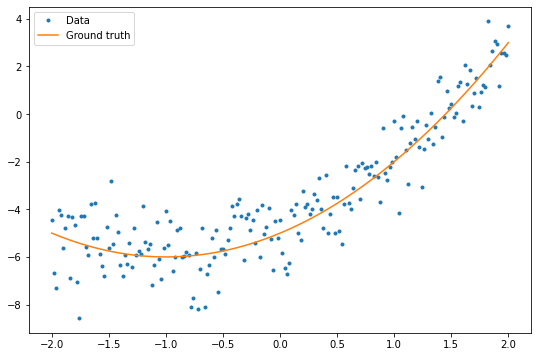

In [4]:
# Self-explanatory imports
import tensorflow as tf
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# Allows the plots to appear in a notebook
%matplotlib inline

# Limits GPU usage
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024*5)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

# Sets run-time parameters
matplotlib.rcParams['figure.figsize'] = [9, 6] # Size of the figure in inches

# Generates 201 evenly spaced values between -2 and 2
x = tf.linspace(-2, 2, 201)
x = tf.cast(x, tf.float32)

# Just some function we're plotting, in this case it's a parabola
def f(x):
  y = x**2 + 2*x - 5
  return y

# the random.normal code produces 201 (given by shape) points as a vector following a
# normal distribution with mean 0 and standard deviation 1 (default values)
y = f(x) + tf.random.normal(shape=[201])

# Add a scatteplot to the plot
plt.plot(x.numpy(), y.numpy(), '.', label='Data')
# Add the parabola to the plot
plt.plot(x, f(x), label='Ground truth')
# Add a legend to the plot
plt.legend();


- The above code generates a parabola and a scatterplot of the same parabola with some noise added via a [normal distribution](https://www.tensorflow.org/api_docs/python/tf/random/normal).
- The below code creates a machine learning model to try to fit to the noisy data. A seed of `22` is used as an example here, but what's happening is we're generating a random quadratic equation (not random if we use a constant seed) which we'll later use to fit to the data. Note: re-running the code block without restarting the kernel will just keep pulling different numbers, but restarting the kernel and running the cell will result in the same initial weights and bias values.

In [5]:
class Model(tf.Module):

  def __init__(self):
    # Randomly generate weight and bias terms
    rand_init = tf.random.uniform(shape=[3], minval=0., maxval=5., seed=22)
    # Initialize model parameters
    self.w_q = tf.Variable(rand_init[0])
    self.w_l = tf.Variable(rand_init[1])
    self.b = tf.Variable(rand_init[2])
    
  def print_weights(self):
    # the .numpy() converts the variable to a float
    # this fancy print is similar to printf in C/C++, where the curly braces specifies the formatting
    # here, I'm printing each value as a float with 3 decimal places
    print("w_q: {0:.3f}, w_l: {1:.3f}, b: {2:.3f}".format(self.w_l.numpy(), self.w_q.numpy(), self.b.numpy()))

  # Creates a tensorflow graph, used for optimization purposes
  @tf.function
  def __call__(self, x):
    # Quadratic Model : quadratic_weight * x^2 + linear_weight * x + bias
    return self.w_q * (x**2) + self.w_l * x + self.b

# Initialize our class and print the weights
quad_model = Model()
quad_model.print_weights()

quad_model2 = Model()
quad_model2.print_weights()

w_q: 4.387, w_l: 1.429, b: 4.689
w_q: 2.332, w_l: 4.938, b: 2.592


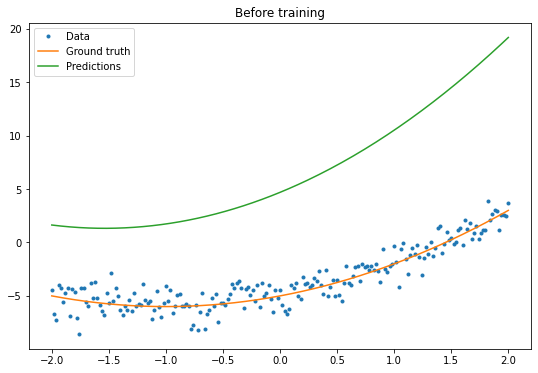

In [6]:
# Make a plot of our initialized model
def plot_preds(x, y, f, model, title):
  plt.figure()
  plt.plot(x, y, '.', label='Data')
  plt.plot(x, f(x), label='Ground truth')
  plt.plot(x, model(x), label='Predictions')
  plt.title(title)
  plt.legend()

plot_preds(x, y, f, quad_model, 'Before training')

- Now that we have a model with parameters we can modify, we need to be able to minimize our loss. Here, we'll be using mean squared error, which is defined as:

<img src="./Images/MSE.jpg" alt="MSE Formula" width="400"/>

In [7]:
# Our mean squared error function, y_pred and y are vectors
def mse_loss(y_pred, y):
    return tf.reduce_mean(tf.square(y_pred - y))

- The tutorial then makes use of batching, which we talked about in class, to improve computation speed and have memory savings. First I cover some code we'll be seeing when working with the batching code.

In [8]:
# Dummy data
x2 = tf.Variable([1,2])
y2 = tf.Variable([3,4])

# A dataset is used for processing large amounts of data efficiently

print("One 1D Tensor as input to from_tensors:")
# Create a dataset from one 1D tensor
dataset = tf.data.Dataset.from_tensors(y2)
# Print this dataset by converting to numpy, note that the function "from_tensors" creates a
# single element dataset
print(list(dataset.as_numpy_iterator()))

print("\nOne 1D Tensor as input to from_tensor_slices:")
dataset = tf.data.Dataset.from_tensor_slices(y2)
print(list(dataset.as_numpy_iterator()))

print("\nOne 2D Tensor as input to from_tensor_slices:")
# One 2D tensor input
dataset = tf.data.Dataset.from_tensor_slices([x2,y2,x2])
print(list(dataset.as_numpy_iterator()))

print("\nOne tuple of 1D Tensors input to from_tensor_slices:")
# One tuple of 1D tensors creates a 1D tensor where the values of each input tensor are combined
dataset = tf.data.Dataset.from_tensor_slices((x2,y2,x2))
print(list(dataset.as_numpy_iterator()))

One 1D Tensor as input to from_tensors:
[array([3, 4], dtype=int32)]

One 1D Tensor as input to from_tensor_slices:
[3, 4]

One 2D Tensor as input to from_tensor_slices:
[array([1, 2], dtype=int32), array([3, 4], dtype=int32), array([1, 2], dtype=int32)]

One tuple of 1D Tensors input to from_tensor_slices:
[(1, 3, 1), (2, 4, 2)]


- This last example is what we'll be doing with our data, effectively "zipping" our x and y tensors into a list of individual (x0,y0) data points. The [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) class in Tensorflow does have a [zip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip) function, but it expects datasets as inputs and the function `from_tensor_slices` takes Tensors as input, which I assume is just a cleaner way of zipping values.
- Now I'll show an example of how batching works with randomization:

In [9]:
# Dummy data
x2 = tf.Variable([1,2,3,4,5,6,7,8])
y2 = tf.Variable([9,10,11,12,13,14,15,16])

# Zip together our tensors

dataset = tf.data.Dataset.from_tensor_slices((x2,y2))
print("Dataset before randomization:\n",list(dataset.as_numpy_iterator()))

# Shuffles the data by filling a buffer of size buffer_size randomly

# Seed of 22 just for keeping the values the same in the text block below
# Reshuffle_each_iteration is False because otherwise the prints are confusing
dataset = dataset.shuffle(buffer_size=x2.shape[0], reshuffle_each_iteration=False)
print("\nDataset after randomization:\n",list(dataset.as_numpy_iterator()))

# Batch size of 2

dataset = dataset.batch(2)
print("\nDataset after batching:\n",list(dataset.as_numpy_iterator()))

# Printing the final result
for i in range(0, len(list(dataset.as_numpy_iterator()))):
    batch = list(dataset.as_numpy_iterator())[i]
    print("\nBatch #{0:d} values:".format(i))
    print("x-values: ", batch[0])
    print("y-values: ", batch[1])

Dataset before randomization:
 [(1, 9), (2, 10), (3, 11), (4, 12), (5, 13), (6, 14), (7, 15), (8, 16)]

Dataset after randomization:
 [(3, 11), (4, 12), (6, 14), (7, 15), (2, 10), (8, 16), (5, 13), (1, 9)]

Dataset after batching:
 [(array([3, 4], dtype=int32), array([11, 12], dtype=int32)), (array([6, 7], dtype=int32), array([14, 15], dtype=int32)), (array([2, 8], dtype=int32), array([10, 16], dtype=int32)), (array([5, 1], dtype=int32), array([13,  9], dtype=int32))]

Batch #0 values:
x-values:  [3 4]
y-values:  [11 12]

Batch #1 values:
x-values:  [6 7]
y-values:  [14 15]

Batch #2 values:
x-values:  [2 8]
y-values:  [10 16]

Batch #3 values:
x-values:  [5 1]
y-values:  [13  9]


- So, what this has done is taken our nice 1D tensor of tuples representing our data as points and grouped it batches of size 2 after randomization. Each batch contains two of our original points, in the same order, but it's formatted strangely. The x-values are in their own array and y-values are in a separate array. See the functions [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) for more info.

In [10]:
# Recall x and y contain the noisy data we're trying to fit to

# Size of the batches
batch_size = 32

# So the input here (x,y) creates a list of tuples, where each tuple is an individual data point (x0,y0)
dataset = tf.data.Dataset.from_tensor_slices((x, y))

# Shuffles the data by filling a buffer of size buffer_size randomly
# (here it's the entire size of our list of tuples) and selects the first batch_size elements
# effectively allowing us to select the first 32 elements randomly

# print first 3 elements after shuffling
# Once again reshuffle_each_iteration=False so that I can demonstrate with prints what's happening
dataset = dataset.shuffle(buffer_size=x.shape[0], reshuffle_each_iteration=False)
for i in range(0,3) :
    print("Before batch, element {0}: ({1:.6f}, {2:.6f})".format(i,\
        list(dataset.as_numpy_iterator())[i][0],\
        list(dataset.as_numpy_iterator())[i][1]))

print()
    
# print first 3 elements after selecting our batch
# recall the funky formatting that occurs once the batching occurs
dataset = dataset.batch(batch_size)

for i in range(0,3) :
    print("After batch, element {0}: ({1:.6f}, {2:.6f})".format(i,\
         list(dataset.as_numpy_iterator())[0][0][i],\
         list(dataset.as_numpy_iterator())[0][1][i]))

print()
# Number of batches, note that the last batch isn't necessarily 32 samples, but can be
# forced to be with the option `drop_remainder` for the `batch` function
print("Number of batches:\n",dataset.__len__())

Before batch, element 0: (0.820000, -2.620229)
Before batch, element 1: (0.900000, -0.567911)
Before batch, element 2: (0.860000, -2.647676)

After batch, element 0: (0.820000, -2.620229)
After batch, element 1: (0.900000, -0.567911)
After batch, element 2: (0.860000, -2.647676)

Number of batches:
 tf.Tensor(7, shape=(), dtype=int64)


- Now we can train our model

Initial mean squared error: 111.73252868652344
Mean squared error for step 0: 55.145
w_q: 3.993, w_l: -0.103, b: 3.484
Weights: None
Mean squared error for step 10: 9.285
w_q: 2.331, w_l: -1.025, b: -0.576
Weights: None
Mean squared error for step 20: 3.801
w_q: 2.066, w_l: -0.226, b: -2.343
Weights: None
Mean squared error for step 30: 1.962
w_q: 2.018, w_l: 0.254, b: -3.384
Weights: None
Mean squared error for step 40: 1.340
w_q: 2.006, w_l: 0.539, b: -4.000
Weights: None
Mean squared error for step 50: 1.133
w_q: 2.001, w_l: 0.707, b: -4.363
Weights: None
Mean squared error for step 60: 1.068
w_q: 1.999, w_l: 0.807, b: -4.578
Weights: None
Mean squared error for step 70: 1.049
w_q: 1.998, w_l: 0.865, b: -4.705
Weights: None
Mean squared error for step 80: 1.044
w_q: 1.997, w_l: 0.900, b: -4.781
Weights: None
Mean squared error for step 90: 1.044
w_q: 1.996, w_l: 0.921, b: -4.825
Weights: None




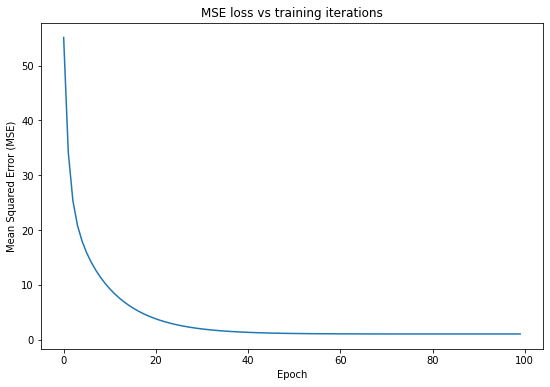

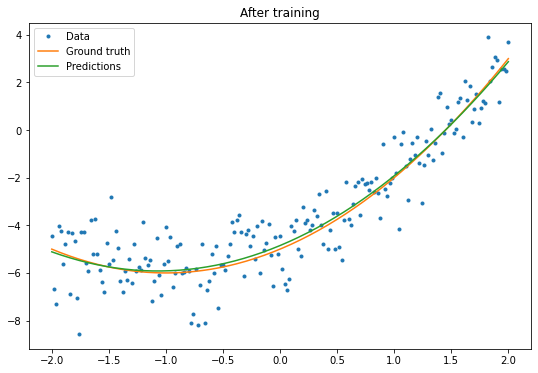

In [11]:
# Set training parameters
epochs = 100 # The number of iterations in our training loop
learning_rate = 0.01 # Scalar multiplier for how much our variables change with respect to our computed gradients
losses = [] # Contains a list of size epochs of the loss of our model at each iteration

print(f'Initial mean squared error: {mse_loss(quad_model(x),y).numpy()}')

# Outermost training loop
for epoch in range(epochs):
  # Grab each batch, x_batch contains x-values and y_batch contains corresponding y-values
  for x_batch, y_batch in dataset:
    # Allows us to take the gradient of our loss
    with tf.GradientTape() as tape:
      # Calculate our loss
      batch_loss = mse_loss(quad_model(x_batch), y_batch)
    # Update parameters with respect to the gradient calculations
    # Partial of our loss function with respect to our variables (3 variables in our model)
    # So, `grads` contains 3 values, each is the gradient of our loss with respect to a variables
    grads = tape.gradient(batch_loss, quad_model.variables)
    # Update our variables from the gradient and the learning rate
    for g,v in zip(grads, quad_model.variables):
        v.assign_sub(learning_rate*g)
  # Keep track of model loss per epoch
  loss = mse_loss(quad_model(x), y)
  losses.append(loss)
  # Print every 10 epochs since it looks nice
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {loss.numpy():0.3f}')
    print("Weights:",quad_model.print_weights())

# Plot model results
print("\n")
plt.plot(range(epochs), losses)
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.title('MSE loss vs training iterations');

plot_preds(x, y, f, quad_model, 'After training')


- So, we've now trained our model and plot our updated quadratic

- Recall that in batching I set `reshuffle_each_iteration=False`, so this means we were iterating over the same batches in the same order every epoch, will our model fit better if we set this parameter to `True` so that each epoch iterators over a different list of batches?
- Below I import two files containing the final MSE of training where reshuffle is false and another where reshuffle is true. These files are in the repository titled `MSE_False.txt` and `MSE_True.txt` (100 data points each, generated from `generate_data.py`). I pre-processed these files so that it doesn't take forever to re-run this notebook.

In [12]:
# Read from file, converting each line to a float and appending to floats list
file = open("./Helper/MSE_False.txt", "r")
file.seek(0)
lines = []
lines = file.readlines()
floats_false = []
for line in lines:
    floats_false.append(float(line))
file.close()

file = open("./Helper/MSE_True.txt", "r")
file.seek(0)
lines = []
lines = file.readlines()
floats_true = []
for line in lines:
    floats_true.append(float(line))
file.close()

# Get standard deviation and mean
print("Reshuffle is False:\nMean\n", np.mean(floats_false), "\nStandard Deviation\n", np.std(floats_false))
print("\nReshuffle is True:\nMean\n", np.mean(floats_true), "\nStandard Deviation\n", np.std(floats_true))

# Print +/- 2 standard deviations
print("\nReshuffle is false mean +/- 2 standard deviations:\n", "({0:.6f}, {1:.6f})".\
      format(np.mean(floats_false) - 2*np.std(floats_false), np.mean(floats_false) + 2*np.std(floats_false)))
print("Reshuffle is true, mean +/- 2 standard deviations:\n", "({0:.6f}, {1:.6f})".\
      format(np.mean(floats_true) - 2*np.std(floats_true), np.mean(floats_true) + 2*np.std(floats_true)))

Reshuffle is False:
Mean
 0.95857126 
Standard Deviation
 4.7794899309443215e-05

Reshuffle is True:
Mean
 0.9609397999999999 
Standard Deviation
 0.0014336847142939035

Reshuffle is false mean +/- 2 standard deviations:
 (0.958476, 0.958667)
Reshuffle is true, mean +/- 2 standard deviations:
 (0.958072, 0.963807)


- From this, we see there is no statistical significance to having the reshuffle parameter as true. Thus, for this example, reshuffle doesn't really matter.
- The tutorial then goes through and shows us how to use `keras` to create and train a model.

INFO:tensorflow:Assets written to: ./my_new_model/assets


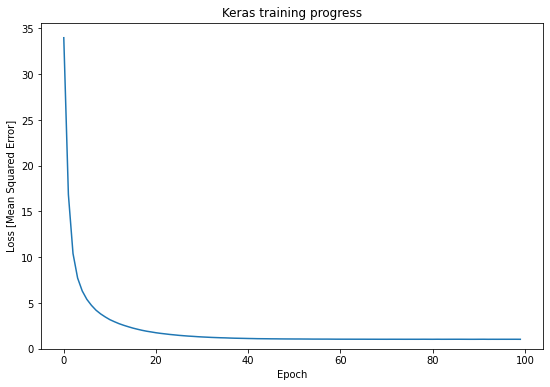

In [13]:
# Create a keras model
new_model = tf.keras.Sequential([
    # This layer creates the input to the dense layer, taking x values and converting
    # them to a vector of [x, x^2]
    # Note that the constant term is handled by the bias of the dense layer
    tf.keras.layers.Lambda(lambda x: tf.stack([x, x**2], axis=1)),
    # This is a standard dense layer, input is 2-D and output is 1-D (the approximate solution)
    tf.keras.layers.Dense(1, kernel_initializer=tf.random.normal)])

# Turn the model into something we can train
new_model.compile(
    # Mean squared error loss function
    loss=tf.keras.losses.MSE,
    # Our gradient descent is just SGD
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

# Run the training
history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=0)

new_model.save('./my_new_model')

plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss [Mean Squared Error]')
plt.title('Keras training progress');


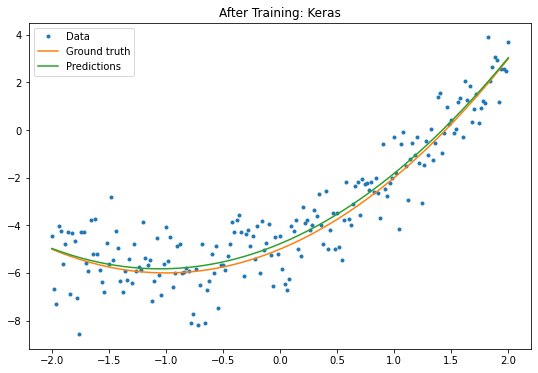

In [14]:
plot_preds(x, y, f, new_model, 'After Training: Keras')

- This completes the basic tutorial!

### Model Graphing

- This next exploration is motivated by wanting to see my models in an easier to digest format through tensorboard.
- I will be implementing the code from [this tutorial](https://www.tensorflow.org/tensorboard/graphs).
- Below, we first make sure our notebook is capable of working with tensorboard.

In [15]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

# Necessary imports
from datetime import datetime
from packaging import version
import tensorflow as tf
from tensorflow import keras

# Check we have the right tensorflow version before importing tensorflow
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

import tensorboard
print(f"Tensorboard version: {tensorboard.__version__:s}")

TensorFlow version:  2.9.1
Tensorboard version: 2.9.0


In [16]:
# Bash command to clear our log folder to store data needed for tensorboard
!rm -r ./logs

- Here, I define the same keras model as above, except this time I add a callback function provided by tensorboard which will populate a local `logs` folder with necessary information needed by tensorboard.
- Note, I set `verbose=1` due to [this issue](https://github.com/tensorflow/tensorboard/issues/1929) which explains it fixes some error I was encountering when viewing my model in tensorboard.

In [17]:
# Create a keras model, for more detail see the same model higher up in this notebook
new_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.stack([x**2, x], axis=1)),
    tf.keras.layers.Dense(1, kernel_initializer=tf.random.normal)])

new_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01))

# NEW: define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

history = new_model.fit(x, y,
                        epochs=100,
                        batch_size=32,
                        verbose=1, #NEW: added to make tensorboard happy with more data
                        callbacks=[tensorboard_callback]) #NEW: callback for tensorboard

Epoch 1/100
7/7 [==============================] - 0s 3ms/step - loss: 29.6106
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 17.4040
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 11.9340
Epoch 4/100
7/7 [==============================] - 0s 2ms/step - loss: 9.3418
Epoch 5/100
7/7 [==============================] - 0s 2ms/step - loss: 7.6389
Epoch 6/100
7/7 [==============================] - 0s 2ms/step - loss: 6.4473
Epoch 7/100
7/7 [==============================] - 0s 2ms/step - loss: 5.5798
Epoch 8/100
7/7 [==============================] - 0s 2ms/step - loss: 4.9071
Epoch 9/100
7/7 [==============================] - 0s 2ms/step - loss: 4.3865
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 3.9347
Epoch 11/100
7/7 [==============================] - 0s 2ms/step - loss: 3.5686
Epoch 12/100
7/7 [==============================] - 0s 3ms/step - loss: 3.2796
Epoch 13/100
7/7 [==============================] - 0s 3ms

- This line then initializes tensorboard and outputs a nice gui. This gui can be accessed in your browser by searching `localhost:[port]`, where `[port]` is given in the output of the below code block.

In [18]:
%tensorboard --logdir logs

<img src="./Images/TensorBoard.png" alt="Tensoarboard Graph 1" width="700"/>

<img src="./Images/TensorBoard2.png" alt="Tensoarboard Graph 2" width="300"/>

- The above are two graphs generated by tensorboard. The first one is very confusing, but shows the exact operations being used for this model. The second is a more condensed version but doesn't give me too much information. I guess I'll have to stick with the below `.summary()` function to analyze my models for now.
- [This page](https://keras.io/api/layers/base_layer/#getweights-method) explains that the `get_weights()` method returns weights and biases for the specified layer.

In [19]:
# Summarize data
new_model.summary()

# Get weights and biases for the dense layer to get the approximated polynomial
# The lambda layer just converts an input x to a vector [x^2,x] (the constant is implied with the constant bias)
weights = new_model.layers[1].get_weights()
# From the weights, the first index specifies if it's a weight [0] or bias [1]
# the second index specifies what number weight it is
# The third index just pulls the value out of a 1-value array into a float
a = weights[0][0][0]
b = weights[0][1][0]
c = weights[1][0]

# Prints the weights with 4 digits of precision
print(f"\nOur model has found the polynomial {a:.4f}x^2 + {b:.4f}x + {c:.4f}")
print("Which is an approximation to x^2 + 2*x - 5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 2)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________

Our model has found the polynomial 0.9401x^2 + 1.9786x + -4.7660
Which is an approximation to x^2 + 2*x - 5


### ImageNet Analysis

- We'll now be taking a look at the ImageNet data set. Looking at [Tensorflow's Dataset](https://www.tensorflow.org/datasets/catalog/imagenet2012) page, I see that I need to download `ILSVRC2012_img_train.tar` and `ILSVRC2012_img_val.tar` from [Imagenet's website](https://image-net.org).
- Then, I ran `pip install tensorflow-datasets`.
- After doing so, I can load the dataset by following the first part of [these instructions](https://medium.com/analytics-vidhya/how-to-train-a-neural-network-classifier-on-imagenet-using-tensorflow-2-ede0ea3a35ff). Note that my `/tf/Datasets/` directory has the files `ILSVRC2012_img_train.tar` and `ILSVRC2012_img_val.tar`.
- The labels were converted from integers to strings through [this file](https://github.com/arthw/imagenet_label/blob/master/imagenet_1000.txt) I found online, which I also put in the `/tf/Datasets` directory.
- Note: I originally wanted to have the dataset on an external hard drive I had with much more storage (2TB) than my boot drive (500GB), but the external hard drive uses NTFS (a windows file system) and it's VERY slow on Linux because of a translation layer for IO operations, so I ended up wasting a day moving everything off that drive to my boot drive with much more limited free storage. The above tutorial is nice in my situation since it only loads 1% of the data, allowing my to study the data set without needing to buy a new hard drive.

In [20]:
# Imports

# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow_datasets as tfds

# Helper libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Print images
from matplotlib import pyplot as plt

In [21]:
# Get imagenet labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

# Set data_dir to a read-only storage of .tar files
# Set write_dir to a w/r storage
data_dir = '/tf/Datasets/'
write_dir = '/tf/Datasets/write_dir'

# Construct a tf.data.Dataset
download_config = tfds.download.DownloadConfig(
                      extract_dir=os.path.join(write_dir, 'extracted'),
                      manual_dir=data_dir
                  )

download_and_prepare_kwargs = {
    'download_dir': os.path.join(write_dir, 'downloaded'),
    'download_config': download_config,
}

ds = tfds.load('imagenet2012_subset',  # Note: the `_subset` allows us to study 1% of the underlying data
               data_dir=os.path.join(write_dir, 'data'), # Where we have our local files    
               split='train', # Load the training data
               shuffle_files=False, # Don't shuffle files
               download=False, # We've already downloaded the data
               as_supervised=True) # Each point in the dataset is a tuple of (input, label)

# Shuffle our data, see earlier in this notebook for details
ds_size = ds.__len__()
ds = ds.shuffle(buffer_size=ds_size, reshuffle_each_iteration=False, seed=24)

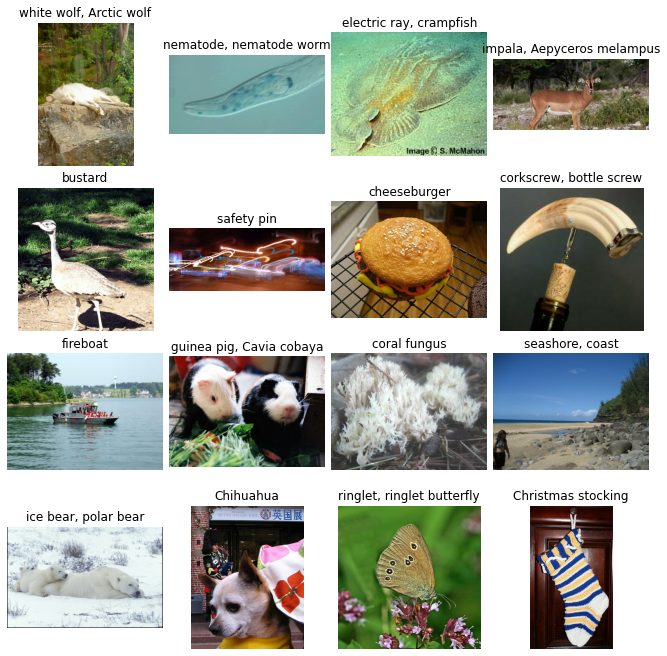

In [22]:
# Print first ncols*nrows images
ncols = 4
nrows = 4
fig1, f1_axes = plt.subplots(ncols=ncols, nrows=nrows, constrained_layout=True, figsize=(9,9))
num_images = ncols*nrows

# Take num_images images from the dataset
ex = ds.take(num_images)

# Get labels as strings
labels = open("/tf/Datasets/labels.txt", "r")
labels.seek(0)
labels_list = labels.readlines()
labels.close()

# Make our grid and populate it with images
i = 0
for img, label in ex:
    # Indexing variables for our matplotlib grid
    r = i//ncols
    c = i%nrows
    # Get the axis we are going to populate
    ax = f1_axes[r][c]
    # Turn off axes and grid markers
    ax.set_axis_off()
    # Add the image
    ax.imshow(img)
    # Ugly string manipulation to make the title's pretty:
    ax.set_title(",".join(" ".join(labels_list[np.asarray(label)].split()[1:]).split(',')[0:2]))
    i = i+1
    
plt.show()

- From the above, we can see that the images in the dataset are highly non-trivial. For example, the image above labeled "corkscrew" could be interpreted as "claw"  by a human, which is a valid label (label 600) in imagenet. This non-triviality is probably what makes this dataset so difficult to work with when deisgning neural nets.
- Aside from potentially having ambiguous labels, it's clear that the images have a lot going on in them. Each of the images has a lot of background, which introduces noise in the classification task. For example, the chihuahua is covered in a blanket with some floral pattern, introducing noise.
- Lets look at the composition of the images in this data set:

In [23]:
ex = ds.take(1)

# Get the shape of the first image
i = 0
for img, label in ex:
    shape = img.get_shape()
    print("Image dimensions:", img.get_shape())
    print("First pixel values:", np.asarray(img[0][0]))

Image dimensions: (500, 332, 3)
First pixel values: [21 20  2]


- From the previous prints, we see that the "barbell" example has height 375 pixels, width 500 pixels, and each pixel is a vector of length 3. So, it's safe to assume each pixel just contains values for red, green, and blue levels. I show below that every image has a vector length of 3.
- Now, let's create some pretty plots to show the kind of data we're seeing in imagenet. Note that these plots represent a 1% subsample of the entirety of imagenet, but it should give us a good idea of what's in the entire dataset anyways.

In [24]:
# lists we'll be using to fill our data:
heights = list()
widths = list()
tuples = list()
pixel_len = list()

for img, label in ds:
    shape = img.get_shape()
    heights.append(shape[0])
    widths.append(shape[1])
    pixel_len.append(shape[2])
    tuples.append((shape[0], shape[1]))

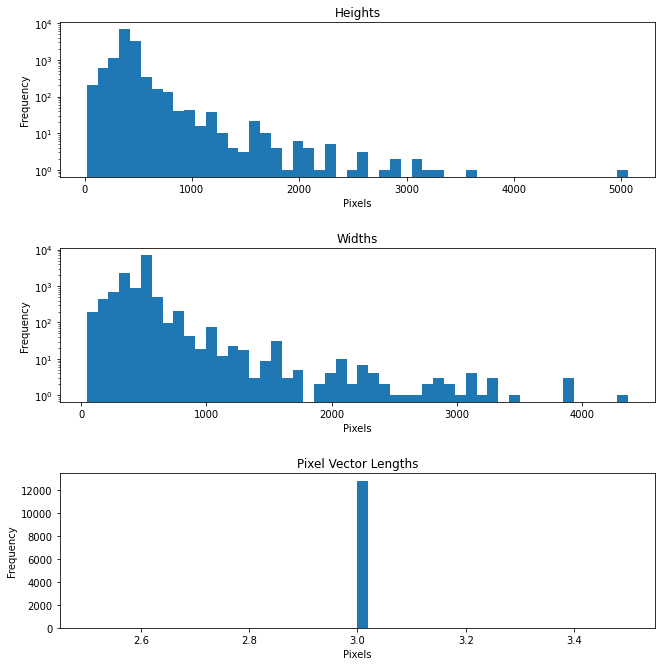

In [25]:
# Create our matplotlib grid
ncols = 1
nrows = 3
fig2, f2_axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(9,9))
fig2.tight_layout(h_pad=5)
num_images = ncols*nrows

# Make our data easier to iterate over
data = [heights, widths, pixel_len]
titles = ["Heights", "Widths", "Pixel Vector Lengths"]

# Add our histograms
for c in range(3):
    # Get the axis we are going to populate
    ax = f2_axes[c]
    # Add the image
    ax.hist(data[c], bins=50, log=True if c in [0,1] else False)
    # Add title
    ax.set_title(titles[c])
    ax.set_ylabel("Frequency")
    ax.set_xlabel("Pixels")
    
plt.show()

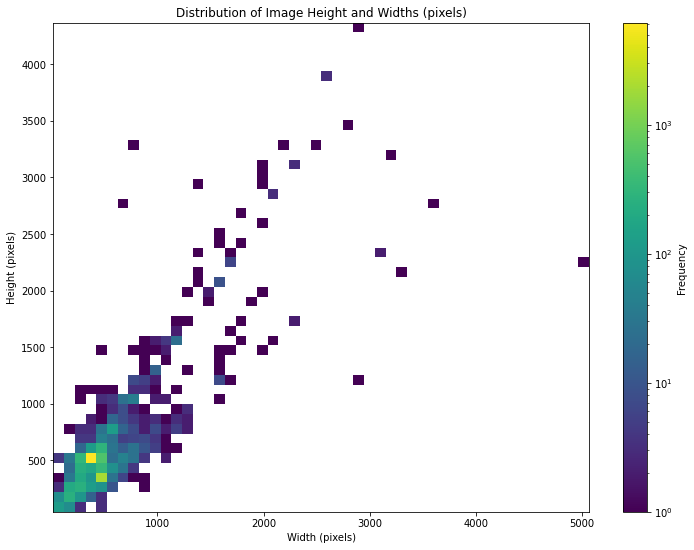

In [26]:
import matplotlib as mpl
from matplotlib.colors import LogNorm

# Create our matplotlib grid
ncols = 1
nrows = 1
fig3, f3_axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12,9))
num_images = ncols*nrows

# Get the axis we are going to populate
ax = f3_axes
# Add the image
hh = ax.hist2d(data[0], data[1], bins=50, norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
# Add title
ax.set_title("Distribution of Image Height and Widths (pixels)")
ax.set_ylabel("Height (pixels)")
ax.set_xlabel("Width (pixels)")

cb = fig3.colorbar(hh[3], ax=ax)
cb.set_label("Frequency", rotation=90)

plt.show()

In [27]:
import statistics
from statistics import mode, mean, stdev
print("Most common image size is:", mode(tuples))
print()
print("Mean, stdev of image height is:       {:.3f}, {:.3f}".format(mean(heights), stdev(heights)))
print("Mean, stdev of image width is:        {:.3f}, {:.3f}".format(mean(widths), stdev(widths)))
print("Mean, stdev of image pixel length is: {:.3f}, {:.3f}".format(mean(pixel_len), stdev(pixel_len)))

Most common image size is: (375, 500)

Mean, stdev of image height is:       405.451, 181.805
Mean, stdev of image width is:        471.499, 209.397
Mean, stdev of image pixel length is: 3.000, 0.000


- What do these figures represent about the data?
- These figures show that the sizes of the images as tensors varies a lot in terms of image height and width (see the mean and standard deviation of height and width). The distributions are slanted, with more images appearing for relatively smaller height and width values. This proves what we discussed in class: that convolutional neural networks (CNNs) are very useful in image classification because they make no assumptions about the size of the input image. Thus, CNNs are input-size agnostic, allowing for image classification after training to allow for multiple different types of image sizes. For example, say we trained a CNN on imagenet, then we can classify whatever image we want (regardless of its dimensions) on the CNN because of the implicit structure of the model.
- This variation, however, doesn't account for pixel length. For each image in imagenet, the pixel consists of three channels: red, green, and blue. It is possible for other data sets to vary in this dimension as well, for example, if there is an alpha channel explaining how opaque/transparent a certain pixel is. This, however, isn't a strict necessity since if you have an image with an alpha channel you can cast it into a 3-channel RGB image anyways. I am not sure off the top of my head in which application you would want to train with the alpha channel; however, traditional CNNs would need to be modified to account for the variability in this dimension.